# Donwload the dataset

In [2]:
from roboflow import Roboflow
from apikey import secret # the api token to download the dataset
rf = Roboflow(api_key=secret)
project = rf.workspace("roboflow-100").project("construction-safety-gsnvb")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import torch
from super_gradients.training import models

MODEL_ARCH = 'yolo_nas_s'
BATCH_SIZE = 8
MAX_EPOCHS = 25
CHECKPOINT_DIR = f'checkpoints'
EXPERIMENT_NAME = 'safety'
CLASSES = sorted(project.classes.keys())
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset_params = {
    'data_dir': 'construction-safety-2',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2024-05-02 20:03:48] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 997/997 [00:02<00:00, 473.88it/s]
[2024-05-02 20:03:51] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 119/119 [00:00<00:00, 631.13it/s]
[2024-05-02 20:03:52] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 90/90 [00:00<00:00, 437.24it/s]


In [9]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights=None
).to(DEVICE)

In [10]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs


In [11]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [12]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2024-05-02 20:06:57] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240502_200657_308425`
[2024-05-02 20:06:57] INFO - sg_trainer.py - Checkpoints directory: checkpoints\safety\RUN_20240502_200657_308425
getargs: The 'u' format is deprecated. Use 'U' instead.
[2024-05-02 20:06:57] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints\safety\RUN_20240502_200657_308425/console_May02_20_06_57.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
getargs: The 'u' format is deprecated. Use 'U' instead.
[2024-05-02 20:07:38] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            997        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5898
│   ├── Ppyoloeloss/loss_iou = 1.3157
│   ├── Ppyoloeloss/loss_dfl = 1.4602
│   └── Ppyoloeloss/loss = 4.3658
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.0398
    ├── Ppyoloeloss/loss_iou = 1.2106
    ├── Ppyoloeloss/loss_dfl = 1.4171
    ├── Ppyoloeloss/loss = 4.6675
    ├── Precision@0.50 = 0.0182
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0022
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.02



Validating epoch 1: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]
[2024-05-02 20:11:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:11:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.010438204742968082


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2196
│   │   ├── Epoch N-1      = 1.5898 (↘ -0.3702)
│   │   └── Best until now = 1.5898 (↘ -0.3702)
│   ├── Ppyoloeloss/loss_iou = 1.2132
│   │   ├── Epoch N-1      = 1.3157 (↘ -0.1025)
│   │   └── Best until now = 1.3157 (↘ -0.1025)
│   ├── Ppyoloeloss/loss_dfl = 1.3113
│   │   ├── Epoch N-1      = 1.4602 (↘ -0.1489)
│   │   └── Best until now = 1.4602 (↘ -0.1489)
│   └── Ppyoloeloss/loss = 3.7442
│       ├── Epoch N-1      = 4.3658 (↘ -0.6216)
│       └── Best until now = 4.3658 (↘ -0.6216)
└── Validation
    ├── Ppyoloeloss/loss_cls = 7.1565
    │   ├── Epoch N-1      = 2.0398 (↗ 5.1166)
    │   └── Best until now = 2.0398 (↗ 5.1166)
    ├── Ppyoloeloss/loss_iou = 1.1254
    │   ├── Epoch N-1      = 1.2106 (↘ -0.0852)
    │   └── Best until now = 1.2106 (↘ -0.0852)
    ├── Ppyoloeloss/loss_dfl = 1.2618
    │   ├── Epoch N-1      = 1.4171 (↘ -0.1553)
    │   └── Best until now = 1.4171 (↘ -0.1553)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]
[2024-05-02 20:12:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:12:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.01766962930560112


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1765
│   │   ├── Epoch N-1      = 1.2196 (↘ -0.0431)
│   │   └── Best until now = 1.2196 (↘ -0.0431)
│   ├── Ppyoloeloss/loss_iou = 1.0693
│   │   ├── Epoch N-1      = 1.2132 (↘ -0.144)
│   │   └── Best until now = 1.2132 (↘ -0.144)
│   ├── Ppyoloeloss/loss_dfl = 1.1425
│   │   ├── Epoch N-1      = 1.3113 (↘ -0.1689)
│   │   └── Best until now = 1.3113 (↘ -0.1689)
│   └── Ppyoloeloss/loss = 3.3882
│       ├── Epoch N-1      = 3.7442 (↘ -0.3559)
│       └── Best until now = 3.7442 (↘ -0.3559)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.009
    │   ├── Epoch N-1      = 7.1565 (↘ -4.1474)
    │   └── Best until now = 2.0398 (↗ 0.9692)
    ├── Ppyoloeloss/loss_iou = 0.9658
    │   ├── Epoch N-1      = 1.1254 (↘ -0.1596)
    │   └── Best until now = 1.1254 (↘ -0.1596)
    ├── Ppyoloeloss/loss_dfl = 1.0944
    │   ├── Epoch N-1      = 1.2618 (↘ -0.1674)
    │   └── Best until now = 1.2618 (↘ -0.1674)
    ├── Ppyoloeloss/loss =

Validating epoch 3: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]
[2024-05-02 20:14:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:14:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.03005678579211235


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1876
│   │   ├── Epoch N-1      = 1.1765 (↗ 0.0111)
│   │   └── Best until now = 1.1765 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.9873
│   │   ├── Epoch N-1      = 1.0693 (↘ -0.082)
│   │   └── Best until now = 1.0693 (↘ -0.082)
│   ├── Ppyoloeloss/loss_dfl = 1.0592
│   │   ├── Epoch N-1      = 1.1425 (↘ -0.0833)
│   │   └── Best until now = 1.1425 (↘ -0.0833)
│   └── Ppyoloeloss/loss = 3.234
│       ├── Epoch N-1      = 3.3882 (↘ -0.1542)
│       └── Best until now = 3.3882 (↘ -0.1542)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7398
    │   ├── Epoch N-1      = 3.009  (↘ -1.2692)
    │   └── Best until now = 2.0398 (↘ -0.3)
    ├── Ppyoloeloss/loss_iou = 0.8965
    │   ├── Epoch N-1      = 0.9658 (↘ -0.0693)
    │   └── Best until now = 0.9658 (↘ -0.0693)
    ├── Ppyoloeloss/loss_dfl = 1.0189
    │   ├── Epoch N-1      = 1.0944 (↘ -0.0755)
    │   └── Best until now = 1.0944 (↘ -0.0755)
    ├── Ppyoloeloss/loss = 3.6

Validating epoch 4: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]
[2024-05-02 20:16:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:16:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.11038653552532196


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1689
│   │   ├── Epoch N-1      = 1.1876 (↘ -0.0186)
│   │   └── Best until now = 1.1765 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.9129
│   │   ├── Epoch N-1      = 0.9873 (↘ -0.0744)
│   │   └── Best until now = 0.9873 (↘ -0.0744)
│   ├── Ppyoloeloss/loss_dfl = 0.9808
│   │   ├── Epoch N-1      = 1.0592 (↘ -0.0784)
│   │   └── Best until now = 1.0592 (↘ -0.0784)
│   └── Ppyoloeloss/loss = 3.0626
│       ├── Epoch N-1      = 3.234  (↘ -0.1714)
│       └── Best until now = 3.234  (↘ -0.1714)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3046
    │   ├── Epoch N-1      = 1.7398 (↘ -0.4353)
    │   └── Best until now = 1.7398 (↘ -0.4353)
    ├── Ppyoloeloss/loss_iou = 0.8195
    │   ├── Epoch N-1      = 0.8965 (↘ -0.0771)
    │   └── Best until now = 0.8965 (↘ -0.0771)
    ├── Ppyoloeloss/loss_dfl = 0.9164
    │   ├── Epoch N-1      = 1.0189 (↘ -0.1025)
    │   └── Best until now = 1.0189 (↘ -0.1025)
    ├── Ppyoloeloss/lo

Validating epoch 5: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]
[2024-05-02 20:18:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:18:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.21608810126781464


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1417
│   │   ├── Epoch N-1      = 1.1689 (↘ -0.0272)
│   │   └── Best until now = 1.1689 (↘ -0.0272)
│   ├── Ppyoloeloss/loss_iou = 0.8457
│   │   ├── Epoch N-1      = 0.9129 (↘ -0.0672)
│   │   └── Best until now = 0.9129 (↘ -0.0672)
│   ├── Ppyoloeloss/loss_dfl = 0.9082
│   │   ├── Epoch N-1      = 0.9808 (↘ -0.0726)
│   │   └── Best until now = 0.9808 (↘ -0.0726)
│   └── Ppyoloeloss/loss = 2.8957
│       ├── Epoch N-1      = 3.0626 (↘ -0.167)
│       └── Best until now = 3.0626 (↘ -0.167)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2599
    │   ├── Epoch N-1      = 1.3046 (↘ -0.0447)
    │   └── Best until now = 1.3046 (↘ -0.0447)
    ├── Ppyoloeloss/loss_iou = 0.756
    │   ├── Epoch N-1      = 0.8195 (↘ -0.0635)
    │   └── Best until now = 0.8195 (↘ -0.0635)
    ├── Ppyoloeloss/loss_dfl = 0.851
    │   ├── Epoch N-1      = 0.9164 (↘ -0.0653)
    │   └── Best until now = 0.9164 (↘ -0.0653)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]
[2024-05-02 20:20:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:20:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.24983301758766174


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1066
│   │   ├── Epoch N-1      = 1.1417 (↘ -0.0351)
│   │   └── Best until now = 1.1417 (↘ -0.0351)
│   ├── Ppyoloeloss/loss_iou = 0.802
│   │   ├── Epoch N-1      = 0.8457 (↘ -0.0437)
│   │   └── Best until now = 0.8457 (↘ -0.0437)
│   ├── Ppyoloeloss/loss_dfl = 0.8561
│   │   ├── Epoch N-1      = 0.9082 (↘ -0.0521)
│   │   └── Best until now = 0.9082 (↘ -0.0521)
│   └── Ppyoloeloss/loss = 2.7648
│       ├── Epoch N-1      = 2.8957 (↘ -0.1308)
│       └── Best until now = 2.8957 (↘ -0.1308)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1926
    │   ├── Epoch N-1      = 1.2599 (↘ -0.0673)
    │   └── Best until now = 1.2599 (↘ -0.0673)
    ├── Ppyoloeloss/loss_iou = 0.7074
    │   ├── Epoch N-1      = 0.756  (↘ -0.0485)
    │   └── Best until now = 0.756  (↘ -0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.8003
    │   ├── Epoch N-1      = 0.851  (↘ -0.0507)
    │   └── Best until now = 0.851  (↘ -0.0507)
    ├── Ppyoloeloss/los

Validating epoch 7: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]
[2024-05-02 20:21:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:21:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.294000506401062


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0828
│   │   ├── Epoch N-1      = 1.1066 (↘ -0.0238)
│   │   └── Best until now = 1.1066 (↘ -0.0238)
│   ├── Ppyoloeloss/loss_iou = 0.7589
│   │   ├── Epoch N-1      = 0.802  (↘ -0.0432)
│   │   └── Best until now = 0.802  (↘ -0.0432)
│   ├── Ppyoloeloss/loss_dfl = 0.8032
│   │   ├── Epoch N-1      = 0.8561 (↘ -0.0529)
│   │   └── Best until now = 0.8561 (↘ -0.0529)
│   └── Ppyoloeloss/loss = 2.6449
│       ├── Epoch N-1      = 2.7648 (↘ -0.1199)
│       └── Best until now = 2.7648 (↘ -0.1199)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2186
    │   ├── Epoch N-1      = 1.1926 (↗ 0.0261)
    │   └── Best until now = 1.1926 (↗ 0.0261)
    ├── Ppyoloeloss/loss_iou = 0.6851
    │   ├── Epoch N-1      = 0.7074 (↘ -0.0223)
    │   └── Best until now = 0.7074 (↘ -0.0223)
    ├── Ppyoloeloss/loss_dfl = 0.7652
    │   ├── Epoch N-1      = 0.8003 (↘ -0.0351)
    │   └── Best until now = 0.8003 (↘ -0.0351)
    ├── Ppyoloeloss/loss

Validating epoch 8: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]
[2024-05-02 20:23:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:23:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.38835519552230835


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0618
│   │   ├── Epoch N-1      = 1.0828 (↘ -0.021)
│   │   └── Best until now = 1.0828 (↘ -0.021)
│   ├── Ppyoloeloss/loss_iou = 0.7328
│   │   ├── Epoch N-1      = 0.7589 (↘ -0.0261)
│   │   └── Best until now = 0.7589 (↘ -0.0261)
│   ├── Ppyoloeloss/loss_dfl = 0.769
│   │   ├── Epoch N-1      = 0.8032 (↘ -0.0343)
│   │   └── Best until now = 0.8032 (↘ -0.0343)
│   └── Ppyoloeloss/loss = 2.5635
│       ├── Epoch N-1      = 2.6449 (↘ -0.0814)
│       └── Best until now = 2.6449 (↘ -0.0814)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0912
    │   ├── Epoch N-1      = 1.2186 (↘ -0.1274)
    │   └── Best until now = 1.1926 (↘ -0.1013)
    ├── Ppyoloeloss/loss_iou = 0.6389
    │   ├── Epoch N-1      = 0.6851 (↘ -0.0462)
    │   └── Best until now = 0.6851 (↘ -0.0462)
    ├── Ppyoloeloss/loss_dfl = 0.7204
    │   ├── Epoch N-1      = 0.7652 (↘ -0.0448)
    │   └── Best until now = 0.7652 (↘ -0.0448)
    ├── Ppyoloeloss/loss 

Validating epoch 9: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0531
│   │   ├── Epoch N-1      = 1.0618 (↘ -0.0087)
│   │   └── Best until now = 1.0618 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.7172
│   │   ├── Epoch N-1      = 0.7328 (↘ -0.0156)
│   │   └── Best until now = 0.7328 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_dfl = 0.752
│   │   ├── Epoch N-1      = 0.769  (↘ -0.0169)
│   │   └── Best until now = 0.769  (↘ -0.0169)
│   └── Ppyoloeloss/loss = 2.5223
│       ├── Epoch N-1      = 2.5635 (↘ -0.0412)
│       └── Best until now = 2.5635 (↘ -0.0412)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1471
    │   ├── Epoch N-1      = 1.0912 (↗ 0.0559)
    │   └── Best until now = 1.0912 (↗ 0.0559)
    ├── Ppyoloeloss/loss_iou = 0.6285
    │   ├── Epoch N-1      = 0.6389 (↘ -0.0104)
    │   └── Best until now = 0.6389 (↘ -0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.7025
    │   ├── Epoch N-1      = 0.7204 (↘ -0.0179)
    │   └── Best until now = 0.7204 (↘ -0.0179)
    ├── Ppyoloeloss/loss 

Validating epoch 10: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]
[2024-05-02 20:27:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:27:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3999341130256653


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0331
│   │   ├── Epoch N-1      = 1.0531 (↘ -0.02)
│   │   └── Best until now = 1.0531 (↘ -0.02)
│   ├── Ppyoloeloss/loss_iou = 0.6894
│   │   ├── Epoch N-1      = 0.7172 (↘ -0.0278)
│   │   └── Best until now = 0.7172 (↘ -0.0278)
│   ├── Ppyoloeloss/loss_dfl = 0.7245
│   │   ├── Epoch N-1      = 0.752  (↘ -0.0275)
│   │   └── Best until now = 0.752  (↘ -0.0275)
│   └── Ppyoloeloss/loss = 2.447
│       ├── Epoch N-1      = 2.5223 (↘ -0.0753)
│       └── Best until now = 2.5223 (↘ -0.0753)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0966
    │   ├── Epoch N-1      = 1.1471 (↘ -0.0505)
    │   └── Best until now = 1.0912 (↗ 0.0054)
    ├── Ppyoloeloss/loss_iou = 0.6257
    │   ├── Epoch N-1      = 0.6285 (↘ -0.0028)
    │   └── Best until now = 0.6285 (↘ -0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.703
    │   ├── Epoch N-1      = 0.7025 (↗ 0.0005)
    │   └── Best until now = 0.7025 (↗ 0.0005)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 11: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]
[2024-05-02 20:30:18] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:30:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.49062615633010864


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0197
│   │   ├── Epoch N-1      = 1.0331 (↘ -0.0134)
│   │   └── Best until now = 1.0331 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.6754
│   │   ├── Epoch N-1      = 0.6894 (↘ -0.014)
│   │   └── Best until now = 0.6894 (↘ -0.014)
│   ├── Ppyoloeloss/loss_dfl = 0.7065
│   │   ├── Epoch N-1      = 0.7245 (↘ -0.018)
│   │   └── Best until now = 0.7245 (↘ -0.018)
│   └── Ppyoloeloss/loss = 2.4017
│       ├── Epoch N-1      = 2.447  (↘ -0.0454)
│       └── Best until now = 2.447  (↘ -0.0454)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0227
    │   ├── Epoch N-1      = 1.0966 (↘ -0.0739)
    │   └── Best until now = 1.0912 (↘ -0.0685)
    ├── Ppyoloeloss/loss_iou = 0.5777
    │   ├── Epoch N-1      = 0.6257 (↘ -0.0479)
    │   └── Best until now = 0.6257 (↘ -0.0479)
    ├── Ppyoloeloss/loss_dfl = 0.6594
    │   ├── Epoch N-1      = 0.703  (↘ -0.0436)
    │   └── Best until now = 0.7025 (↘ -0.0431)
    ├── Ppyoloeloss/loss 

Validating epoch 12: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]
[2024-05-02 20:32:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:32:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5007146000862122


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0129
│   │   ├── Epoch N-1      = 1.0197 (↘ -0.0068)
│   │   └── Best until now = 1.0197 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.6608
│   │   ├── Epoch N-1      = 0.6754 (↘ -0.0146)
│   │   └── Best until now = 0.6754 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.6939
│   │   ├── Epoch N-1      = 0.7065 (↘ -0.0126)
│   │   └── Best until now = 0.7065 (↘ -0.0126)
│   └── Ppyoloeloss/loss = 2.3676
│       ├── Epoch N-1      = 2.4017 (↘ -0.0341)
│       └── Best until now = 2.4017 (↘ -0.0341)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.028
    │   ├── Epoch N-1      = 1.0227 (↗ 0.0053)
    │   └── Best until now = 1.0227 (↗ 0.0053)
    ├── Ppyoloeloss/loss_iou = 0.5736
    │   ├── Epoch N-1      = 0.5777 (↘ -0.0041)
    │   └── Best until now = 0.5777 (↘ -0.0041)
    ├── Ppyoloeloss/loss_dfl = 0.6529
    │   ├── Epoch N-1      = 0.6594 (↘ -0.0065)
    │   └── Best until now = 0.6594 (↘ -0.0065)
    ├── Ppyoloeloss/loss

Validating epoch 13: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0032
│   │   ├── Epoch N-1      = 1.0129 (↘ -0.0097)
│   │   └── Best until now = 1.0129 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.6532
│   │   ├── Epoch N-1      = 0.6608 (↘ -0.0076)
│   │   └── Best until now = 0.6608 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.6846
│   │   ├── Epoch N-1      = 0.6939 (↘ -0.0093)
│   │   └── Best until now = 0.6939 (↘ -0.0093)
│   └── Ppyoloeloss/loss = 2.341
│       ├── Epoch N-1      = 2.3676 (↘ -0.0266)
│       └── Best until now = 2.3676 (↘ -0.0266)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0756
    │   ├── Epoch N-1      = 1.028  (↗ 0.0477)
    │   └── Best until now = 1.0227 (↗ 0.0529)
    ├── Ppyoloeloss/loss_iou = 0.5775
    │   ├── Epoch N-1      = 0.5736 (↗ 0.0038)
    │   └── Best until now = 0.5736 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.6549
    │   ├── Epoch N-1      = 0.6529 (↗ 0.002)
    │   └── Best until now = 0.6529 (↗ 0.002)
    ├── Ppyoloeloss/loss = 2.3

Validating epoch 14: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]
[2024-05-02 20:36:49] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:36:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5612565279006958


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9865
│   │   ├── Epoch N-1      = 1.0032 (↘ -0.0167)
│   │   └── Best until now = 1.0032 (↘ -0.0167)
│   ├── Ppyoloeloss/loss_iou = 0.6385
│   │   ├── Epoch N-1      = 0.6532 (↘ -0.0146)
│   │   └── Best until now = 0.6532 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.6694
│   │   ├── Epoch N-1      = 0.6846 (↘ -0.0152)
│   │   └── Best until now = 0.6846 (↘ -0.0152)
│   └── Ppyoloeloss/loss = 2.2945
│       ├── Epoch N-1      = 2.341  (↘ -0.0465)
│       └── Best until now = 2.341  (↘ -0.0465)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.017
    │   ├── Epoch N-1      = 1.0756 (↘ -0.0586)
    │   └── Best until now = 1.0227 (↘ -0.0057)
    ├── Ppyoloeloss/loss_iou = 0.558
    │   ├── Epoch N-1      = 0.5775 (↘ -0.0195)
    │   └── Best until now = 0.5736 (↘ -0.0156)
    ├── Ppyoloeloss/loss_dfl = 0.6364
    │   ├── Epoch N-1      = 0.6549 (↘ -0.0186)
    │   └── Best until now = 0.6529 (↘ -0.0166)
    ├── Ppyoloeloss/los

Validating epoch 15: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9842
│   │   ├── Epoch N-1      = 0.9865 (↘ -0.0023)
│   │   └── Best until now = 0.9865 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.6322
│   │   ├── Epoch N-1      = 0.6385 (↘ -0.0063)
│   │   └── Best until now = 0.6385 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.6608
│   │   ├── Epoch N-1      = 0.6694 (↘ -0.0086)
│   │   └── Best until now = 0.6694 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 2.2772
│       ├── Epoch N-1      = 2.2945 (↘ -0.0173)
│       └── Best until now = 2.2945 (↘ -0.0173)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9976
    │   ├── Epoch N-1      = 1.017  (↘ -0.0194)
    │   └── Best until now = 1.017  (↘ -0.0194)
    ├── Ppyoloeloss/loss_iou = 0.5493
    │   ├── Epoch N-1      = 0.558  (↘ -0.0087)
    │   └── Best until now = 0.558  (↘ -0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.6311
    │   ├── Epoch N-1      = 0.6364 (↘ -0.0052)
    │   └── Best until now = 0.6364 (↘ -0.0052)
    ├── Ppyoloeloss/l

Validating epoch 16: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]
[2024-05-02 20:40:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:40:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5805124044418335


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9769
│   │   ├── Epoch N-1      = 0.9842 (↘ -0.0073)
│   │   └── Best until now = 0.9842 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.6203
│   │   ├── Epoch N-1      = 0.6322 (↘ -0.012)
│   │   └── Best until now = 0.6322 (↘ -0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.6542
│   │   ├── Epoch N-1      = 0.6608 (↘ -0.0066)
│   │   └── Best until now = 0.6608 (↘ -0.0066)
│   └── Ppyoloeloss/loss = 2.2514
│       ├── Epoch N-1      = 2.2772 (↘ -0.0258)
│       └── Best until now = 2.2772 (↘ -0.0258)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9761
    │   ├── Epoch N-1      = 0.9976 (↘ -0.0214)
    │   └── Best until now = 0.9976 (↘ -0.0214)
    ├── Ppyoloeloss/loss_iou = 0.5385
    │   ├── Epoch N-1      = 0.5493 (↘ -0.0108)
    │   └── Best until now = 0.5493 (↘ -0.0108)
    ├── Ppyoloeloss/loss_dfl = 0.6131
    │   ├── Epoch N-1      = 0.6311 (↘ -0.0181)
    │   └── Best until now = 0.6311 (↘ -0.0181)
    ├── Ppyoloeloss/los

Validating epoch 17: 100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9716
│   │   ├── Epoch N-1      = 0.9769 (↘ -0.0053)
│   │   └── Best until now = 0.9769 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.6168
│   │   ├── Epoch N-1      = 0.6203 (↘ -0.0034)
│   │   └── Best until now = 0.6203 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.6504
│   │   ├── Epoch N-1      = 0.6542 (↘ -0.0039)
│   │   └── Best until now = 0.6542 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 2.2388
│       ├── Epoch N-1      = 2.2514 (↘ -0.0126)
│       └── Best until now = 2.2514 (↘ -0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9719
    │   ├── Epoch N-1      = 0.9761 (↘ -0.0043)
    │   └── Best until now = 0.9761 (↘ -0.0043)
    ├── Ppyoloeloss/loss_iou = 0.5391
    │   ├── Epoch N-1      = 0.5385 (↗ 0.0006)
    │   └── Best until now = 0.5385 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.6131
    │   ├── Epoch N-1      = 0.6131 (↗ 1e-04)
    │   └── Best until now = 0.6131 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 

Validating epoch 18: 100%|██████████| 15/15 [00:27<00:00,  1.81s/it]
[2024-05-02 20:44:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:44:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5914790630340576


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9578
│   │   ├── Epoch N-1      = 0.9716 (↘ -0.0138)
│   │   └── Best until now = 0.9716 (↘ -0.0138)
│   ├── Ppyoloeloss/loss_iou = 0.6073
│   │   ├── Epoch N-1      = 0.6168 (↘ -0.0095)
│   │   └── Best until now = 0.6168 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.6397
│   │   ├── Epoch N-1      = 0.6504 (↘ -0.0107)
│   │   └── Best until now = 0.6504 (↘ -0.0107)
│   └── Ppyoloeloss/loss = 2.2048
│       ├── Epoch N-1      = 2.2388 (↘ -0.034)
│       └── Best until now = 2.2388 (↘ -0.034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.926
    │   ├── Epoch N-1      = 0.9719 (↘ -0.0459)
    │   └── Best until now = 0.9719 (↘ -0.0459)
    ├── Ppyoloeloss/loss_iou = 0.532
    │   ├── Epoch N-1      = 0.5391 (↘ -0.0071)
    │   └── Best until now = 0.5385 (↘ -0.0066)
    ├── Ppyoloeloss/loss_dfl = 0.6093
    │   ├── Epoch N-1      = 0.6131 (↘ -0.0038)
    │   └── Best until now = 0.6131 (↘ -0.0037)
    ├── Ppyoloeloss/loss 

Validating epoch 19: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]
[2024-05-02 20:46:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:46:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6027856469154358


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9474
│   │   ├── Epoch N-1      = 0.9578 (↘ -0.0105)
│   │   └── Best until now = 0.9578 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.6015
│   │   ├── Epoch N-1      = 0.6073 (↘ -0.0058)
│   │   └── Best until now = 0.6073 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.6309
│   │   ├── Epoch N-1      = 0.6397 (↘ -0.0088)
│   │   └── Best until now = 0.6397 (↘ -0.0088)
│   └── Ppyoloeloss/loss = 2.1798
│       ├── Epoch N-1      = 2.2048 (↘ -0.025)
│       └── Best until now = 2.2048 (↘ -0.025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9508
    │   ├── Epoch N-1      = 0.926  (↗ 0.0248)
    │   └── Best until now = 0.926  (↗ 0.0248)
    ├── Ppyoloeloss/loss_iou = 0.5246
    │   ├── Epoch N-1      = 0.532  (↘ -0.0074)
    │   └── Best until now = 0.532  (↘ -0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.6063
    │   ├── Epoch N-1      = 0.6093 (↘ -0.003)
    │   └── Best until now = 0.6093 (↘ -0.003)
    ├── Ppyoloeloss/loss = 

Validating epoch 20: 100%|██████████| 15/15 [00:30<00:00,  2.01s/it]
[2024-05-02 20:48:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:48:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6085063815116882


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9448
│   │   ├── Epoch N-1      = 0.9474 (↘ -0.0026)
│   │   └── Best until now = 0.9474 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.5989
│   │   ├── Epoch N-1      = 0.6015 (↘ -0.0026)
│   │   └── Best until now = 0.6015 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.6281
│   │   ├── Epoch N-1      = 0.6309 (↘ -0.0028)
│   │   └── Best until now = 0.6309 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 2.1718
│       ├── Epoch N-1      = 2.1798 (↘ -0.008)
│       └── Best until now = 2.1798 (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9692
    │   ├── Epoch N-1      = 0.9508 (↗ 0.0185)
    │   └── Best until now = 0.926  (↗ 0.0432)
    ├── Ppyoloeloss/loss_iou = 0.5282
    │   ├── Epoch N-1      = 0.5246 (↗ 0.0036)
    │   └── Best until now = 0.5246 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.6058
    │   ├── Epoch N-1      = 0.6063 (↘ -0.0005)
    │   └── Best until now = 0.6063 (↘ -0.0005)
    ├── Ppyoloeloss/loss = 

Validating epoch 21: 100%|██████████| 15/15 [00:29<00:00,  2.00s/it]
[2024-05-02 20:50:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:50:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6196324825286865


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9402
│   │   ├── Epoch N-1      = 0.9448 (↘ -0.0046)
│   │   └── Best until now = 0.9448 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.5915
│   │   ├── Epoch N-1      = 0.5989 (↘ -0.0074)
│   │   └── Best until now = 0.5989 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.6232
│   │   ├── Epoch N-1      = 0.6281 (↘ -0.0048)
│   │   └── Best until now = 0.6281 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 2.155
│       ├── Epoch N-1      = 2.1718 (↘ -0.0168)
│       └── Best until now = 2.1718 (↘ -0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9398
    │   ├── Epoch N-1      = 0.9692 (↘ -0.0295)
    │   └── Best until now = 0.926  (↗ 0.0138)
    ├── Ppyoloeloss/loss_iou = 0.5227
    │   ├── Epoch N-1      = 0.5282 (↘ -0.0055)
    │   └── Best until now = 0.5246 (↘ -0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.5994
    │   ├── Epoch N-1      = 0.6058 (↘ -0.0064)
    │   └── Best until now = 0.6058 (↘ -0.0064)
    ├── Ppyoloeloss/los

Validating epoch 22: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]
[2024-05-02 20:52:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:52:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6277858018875122


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9345
│   │   ├── Epoch N-1      = 0.9402 (↘ -0.0057)
│   │   └── Best until now = 0.9402 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.59
│   │   ├── Epoch N-1      = 0.5915 (↘ -0.0015)
│   │   └── Best until now = 0.5915 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.6216
│   │   ├── Epoch N-1      = 0.6232 (↘ -0.0017)
│   │   └── Best until now = 0.6232 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 2.146
│       ├── Epoch N-1      = 2.155  (↘ -0.0089)
│       └── Best until now = 2.155  (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9105
    │   ├── Epoch N-1      = 0.9398 (↘ -0.0293)
    │   └── Best until now = 0.926  (↘ -0.0155)
    ├── Ppyoloeloss/loss_iou = 0.5281
    │   ├── Epoch N-1      = 0.5227 (↗ 0.0055)
    │   └── Best until now = 0.5227 (↗ 0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.6027
    │   ├── Epoch N-1      = 0.5994 (↗ 0.0033)
    │   └── Best until now = 0.5994 (↗ 0.0033)
    ├── Ppyoloeloss/loss = 2

Validating epoch 23: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9301
│   │   ├── Epoch N-1      = 0.9345 (↘ -0.0044)
│   │   └── Best until now = 0.9345 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.5871
│   │   ├── Epoch N-1      = 0.59   (↘ -0.0028)
│   │   └── Best until now = 0.59   (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6191
│   │   ├── Epoch N-1      = 0.6216 (↘ -0.0024)
│   │   └── Best until now = 0.6216 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 2.1364
│       ├── Epoch N-1      = 2.146  (↘ -0.0096)
│       └── Best until now = 2.146  (↘ -0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9365
    │   ├── Epoch N-1      = 0.9105 (↗ 0.026)
    │   └── Best until now = 0.9105 (↗ 0.026)
    ├── Ppyoloeloss/loss_iou = 0.5269
    │   ├── Epoch N-1      = 0.5281 (↘ -0.0013)
    │   └── Best until now = 0.5227 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 0.6021
    │   ├── Epoch N-1      = 0.6027 (↘ -0.0007)
    │   └── Best until now = 0.5994 (↗ 0.0027)
    ├── Ppyoloeloss/loss = 

Validating epoch 24: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]
[2024-05-02 20:57:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints\safety\RUN_20240502_200657_308425\ckpt_best.pth
[2024-05-02 20:57:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.635010838508606


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9288
│   │   ├── Epoch N-1      = 0.9301 (↘ -0.0014)
│   │   └── Best until now = 0.9301 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.585
│   │   ├── Epoch N-1      = 0.5871 (↘ -0.0022)
│   │   └── Best until now = 0.5871 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.6164
│   │   ├── Epoch N-1      = 0.6191 (↘ -0.0028)
│   │   └── Best until now = 0.6191 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 2.1301
│       ├── Epoch N-1      = 2.1364 (↘ -0.0063)
│       └── Best until now = 2.1364 (↘ -0.0063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9205
    │   ├── Epoch N-1      = 0.9365 (↘ -0.016)
    │   └── Best until now = 0.9105 (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.522
    │   ├── Epoch N-1      = 0.5269 (↘ -0.0048)
    │   └── Best until now = 0.5227 (↘ -0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.5986
    │   ├── Epoch N-1      = 0.6021 (↘ -0.0035)
    │   └── Best until now = 0.5994 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 

[2024-05-02 20:57:08] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 25: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]
[2024-05-02 20:57:35] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [14]:
#Load the model
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/RUN_20240502_200657_308425/average_model.pth"
).to(DEVICE)

[2024-05-02 21:16:32] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/safety/RUN_20240502_200657_308425/average_model.pth checkpoint.


In [15]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Testing: 100%|██████████| 12/12 [00:37<00:00,  1.40it/s]

{'PPYoloELoss/loss_cls': 0.98580223,
 'PPYoloELoss/loss_iou': 0.55546844,
 'PPYoloELoss/loss_dfl': 0.6080614,
 'PPYoloELoss/loss': 2.1493323,
 'Precision@0.50': 0.0396713986992836,
 'Recall@0.50': 0.8492523431777954,
 'mAP@0.50': 0.5906675457954407,
 'F1@0.50': 0.073318712413311,
 'Best_score_threshold': 0.41999998688697815}

Testing: 100%|██████████| 12/12 [00:38<00:00,  3.18s/it]


# Inference

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


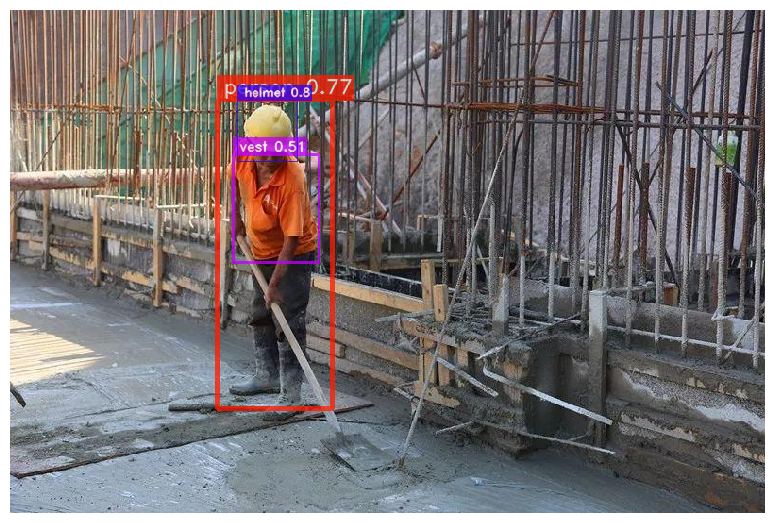

In [19]:
result = model.predict("construction-safety-2/test/images/ppe_0000_jpg.rf.c102a9a7c8dec01565a8f95ff295974c.jpg")
result.show()